# Build a biGRU neural network model with Glove vectors

In this notebook, we are going to build a bidirectional Gated Recurrent Unit neural network model, which will use pre-trained Glove word embeddings instead of training the word representations from scratch.

Glove vectors can be downloaded from the following page: https://nlp.stanford.edu/projects/glove/ 

We will use the *glove.6B.100d* Glove vectors that have been trained on 6 billion tokens from *Wikipedia 2014* and *Gigaword 5* sets. Each embedding has the dimensionality of 100.

In the end, the model will be evaluated on the test set to determine the generalization error.


### Model's architecture
<br>

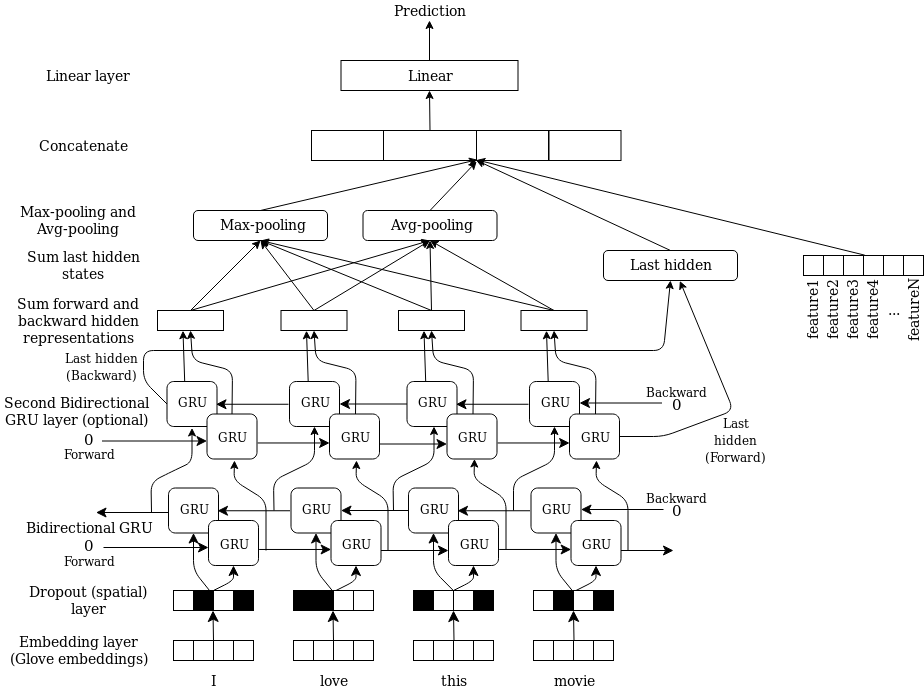

The weight matrix will be created by *BatchIterator* class based on the Glove word vectors we want to use and vocabulary *word2index* dictionary. For each *word, index* pair from *word2index*, the weight matrix at the position equals *index* will be set with the Glove vector that represents given *word*. For words that haven't been found in the Glove mapping, the random vector will be initialized. Then the weight matrix will be passed to the embedding layer as its parameters. It is very important to set the *embedding_layer.weight.requires_grad = False* so that weights will be not updated during the training. We will also use additional features as in the previous model. After the GRU layer, extra features will be concatenated together with max-pooled, avg-pooled and last hidden size. The concatenated tensor will be next passed to the linear layer, so we have to set the input size to hidden_size * 3 + num_features.

### Building and training the model

Let's start with importing all indispensable libraries.

In [36]:
from batch_iterator import BatchIterator
from early_stopping import EarlyStopping
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

Now, we are going to load the tarining and validation sets. We will import sets with all columns except the review column.

In [2]:
# Import the dataset. 
train_dataset = pd.read_csv('dataset/datasets_feat_clean/train_feat_clean.csv', 
                            usecols=['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                                      'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label'])

# Change columns order
train_dataset = train_dataset[['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                               'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label']]

In [3]:
# Depict the first 5 rows of the training set
train_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
0,amaze good wonderful film early ninety franchi...,0.2482,0.5293,391,0.01279,0.002558,0.10740,0.1791,0.2251,0.1381,0.10740,1
1,wrong end see tell chick go crazy eat old woma...,0.1763,0.5750,145,0.00000,0.020690,0.00000,0.2137,0.1724,0.0345,0.07587,0
2,guess emperor clothe see list pbs night hopefu...,0.1145,0.5557,165,0.07880,0.000000,0.13330,0.2303,0.0909,0.2060,0.07275,0
3,earth well movie funny sweet good plot unique ...,0.3810,0.5720,55,0.01819,0.000000,0.01819,0.1637,0.1637,0.1637,0.14550,1
4,doe eye high school student kathleen beller fi...,0.2095,0.4666,688,0.01163,0.001453,0.15550,0.2006,0.1831,0.1846,0.05524,1


Before we create batches of our data, we have to normalize the numerical features so that we remove the possibility that one variable is the orders of magnitude greater than other variables, which might cause that the first one dominates other features in the dataset and this is something we don't want to happen in our model.

The polarity is within the range [-1.0, 1.0], and the subjectivity is within the range [0.0, 1.0], thus these both features don't require the scaling.

In [4]:
# Instantiate the StandardScaler
train_scaler = StandardScaler()
# Scale the features
train_dataset.iloc[:, 3:11] = train_scaler.fit_transform(train_dataset.iloc[:, 3:11])

In [5]:
train_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
0,amaze good wonderful film early ninety franchi...,0.2482,0.5293,0.925766,-0.466051,-0.029506,0.713005,-0.218791,0.986809,-0.090785,0.671761,1
1,wrong end see tell chick go crazy eat old woma...,0.1763,0.5750,-0.503381,-1.032507,3.306467,-1.496461,0.782012,-0.444239,-2.221886,-0.455286,0
2,guess emperor clothe see list pbs night hopefu...,0.1145,0.5557,-0.387190,2.457466,-0.500133,1.245828,1.262165,-2.657338,1.305950,-0.566812,0
3,earth well movie funny sweet good plot unique ...,0.3810,0.5720,-1.026239,-0.226890,-0.500133,-1.122251,-0.664234,-0.680484,0.435819,2.033656,1
4,doe eye high school student kathleen beller fi...,0.2095,0.4666,2.651199,-0.517426,-0.232807,1.702533,0.403095,-0.153684,0.865742,-1.192711,1


In [6]:
# Import the dataset. Use clean_review and label columns
val_dataset = pd.read_csv('dataset/datasets_feat_clean/val_feat_clean.csv',
                          usecols=['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                                      'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label'])

# Change columns order
val_dataset = val_dataset[['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                           'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label']]

In [7]:
# Depict the first 5 rows of the validation set
val_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
0,go movie twice week sum word normally use ligh...,0.272000,0.4656,155,0.01290,0.0,0.05160,0.1807,0.1807,0.1613,0.10320,1
1,year big fan park work old boy time favorite.w...,-0.056670,0.3833,119,0.02520,0.0,0.10080,0.1681,0.1932,0.2185,0.08405,0
2,movie potential handle differently need differ...,-0.012695,0.6560,152,0.03946,0.0,0.01316,0.3157,0.1250,0.1382,0.05920,0
3,movie difficult review give away plot suffice ...,0.148400,0.5910,173,0.01156,0.0,0.08093,0.1849,0.2196,0.1272,0.10406,1
4,plot worth discussion hint corruption murder p...,0.215300,0.5790,105,0.01904,0.0,0.04760,0.1333,0.2856,0.1619,0.16190,0


In [8]:
# Instantiate the StandardScaler
val_scaler = StandardScaler()
# Scale the features
val_dataset.iloc[:, 3:11] = val_scaler.fit_transform(val_dataset.iloc[:, 3:11])

In [9]:
val_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
0,go movie twice week sum word normally use ligh...,0.272000,0.4656,-0.443496,-0.471182,-0.476247,-0.433351,-0.193510,-0.196521,0.377979,0.524956,1
1,year big fan park work old boy time favorite.w...,-0.056670,0.3833,-0.654306,0.091716,-0.476247,0.567055,-0.559484,0.142736,1.531346,-0.157714,0
2,movie potential handle differently need differ...,-0.012695,0.6560,-0.461063,0.744311,-0.476247,-1.214968,3.727638,-1.708251,-0.087803,-1.043581,0
3,movie difficult review give away plot suffice ...,0.148400,0.5910,-0.338090,-0.532506,-0.476247,0.163029,-0.071519,0.859248,-0.309605,0.555614,1
4,plot worth discussion hint corruption murder p...,0.215300,0.5790,-0.736288,-0.190191,-0.476247,-0.514684,-1.570269,2.650526,0.390078,2.617528,0


Below we will use the BatchIterator class defined in the *vocabulary* notebook to create the vocabulary, trim sequences in terms of the rare word occurrence and the length, map words to their numerical representation (word2index), furthermore BatchIterator sorts dataset examples, generates batches, performs sequence padding and enables to use it instance to iterate through all batches.

We use pre-trained embeddings instead of learning them during training process, thus we will create the weights matrix only for the training set.  

To create the weights matrix we have to set use_pretrained_vectors=True and supply the weight file path, Glove vectors file name and the directory and the name of the file to which we will export the prepared weights matrix. To use different word embeddings, simply pass on their file to the BatchIterator class.

In [16]:
train_iterator = BatchIterator(train_dataset, batch_size=64, vocab_created=False, vocab=None, target_col=None,
                               word2index=None, sos_token='<SOS>', eos_token='<EOS>', unk_token='<UNK>',
                               pad_token='<PAD>', min_word_count=3, max_vocab_size=None, max_seq_len=0.9,
                               use_pretrained_vectors=True, glove_path='glove/', glove_name='glove.6B.100d.txt',
                               weights_file_name='glove/weights-biGRU-glove.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
35371/130416 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 198
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 30905/35375 of pre-trained word vectors.
4470 vectors initialized to random numbers
Weights vectors saved into glove/weights.npy
Batches created


In [17]:
val_iterator = BatchIterator(val_dataset, batch_size=64, vocab_created=False, vocab=None, target_col=None,
                             word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                             unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                             max_seq_len=0.9, use_pretrained_vectors=False, glove_path='glove/',
                             glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
19357/59089 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 195
Mapped words to indices
Batches created


We have to check out how batches that we created look like before we pass them into the model. For the record, the set of batches for input and output variables is returned as a dictionary, thus we will just look at the dictionary keys to find out how to extract particular variables.

In [18]:
for batches in train_iterator:
    print(batches.keys())
    break

dict_keys(['input_feat', 'input_seq', 'target', 'x_lengths'])


As we can see above we can distinguish the following batches: *input_feat* that comprises all additional features, *input_seq* that contains cleaned reviews, *target batch* that includes target labels and *x_lengths* batch that encompasses input sequences lengths.

Notice that the *input_seq* batch has the dimensions: (batch_size, seq_len), while *input_feat* batch has the shape of (batch_size, num_features).

In [19]:
for batches in train_iterator:

    # Unpack the dictionary of batches
    input_seq, input_feat, target, x_lengths = batches['input_seq'], batches['input_feat'],\
                                               batches['target'], batches['x_lengths']
        
    print('input_seq shape: ', input_seq.size())
    print('input_feat shape: ', input_feat.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([64, 90])
input_feat shape:  torch.Size([64, 10])
target shape:  torch.Size([64])
x_lengths shape:  torch.Size([64])


In [20]:
for batches in val_iterator:
    # Unpack the dictionary of batches
    input_seq, input_feat, target, x_lengths = batches['input_seq'], batches['input_feat'],\
                                               batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('input_feat shape: ', input_feat.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([64, 115])
input_feat shape:  torch.Size([64, 10])
target shape:  torch.Size([64])
x_lengths shape:  torch.Size([64])


Now we are going to build a biGRU model that will use the pre-trained word embeddings and *input_feat* batch as additional features vector. 

In [26]:
class BiGRU(nn.Module):
    """BiDirectional GRU neural network model with pre-trained word embeddings.
        
    Parameters
    ----------
    hidden_size: int
        Number of features in the hidden state.
    vocab_size: int
        The size of the vocabulary.
    n_extra_feat: int
        Number of additional features.
    weight_matrix: numpy.ndarray
        Matrix of pre-trained word embeddings.
    output_size: int
        Number of classes.
    n_layers: int, optional (default=1)
        Number of stacked recurrent layers.
    dropout: float, optional (default=0.2)
        Probability of an element of the tensor to be zeroed.
    spatial_dropout: boolean, optional (default=True)
        Whether to use the spatial dropout.
    bidirectional: boolean, optional (default=True)
        Whether to use the bidirectional GRU.

    """
    
    def __init__(self, hidden_size, vocab_size, n_extra_feat, weights_matrix, output_size, n_layers=1, dropout=0.2,
                 spatial_dropout=True, bidirectional=True):
        
        # Inherit everything from the nn.Module
        super(BiGRU, self).__init__()
        
        # Initialize attributes
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.n_extra_feat = n_extra_feat
        self.weights_matrix = weights_matrix
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout
        self.spatial_dropout = spatial_dropout
        self.bidirectional = bidirectional
        self.n_directions = 2 if self.bidirectional else 1
        
        self.vocab_size, self.embedding_dim = self.weights_matrix.shape
        
        # Initialize layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        # Load the weights to the embedding layer
        self.embedding.load_state_dict({'weight': torch.from_numpy(weights_matrix)})
        self.embedding.weight.requires_grad = False
        
        self.dropout = nn.Dropout(self.dropout_p)
        if self.spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(self.dropout_p)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_size, num_layers=self.n_layers, 
                          dropout=(0 if n_layers == 1 else self.dropout_p), batch_first=True,
                          bidirectional=self.bidirectional)
        # Linear layer input size is equal to hidden_size * 3 + n_extra_feat, becuase
        # we will concatenate max_pooling ,avg_pooling, last hidden state and additional features
        self.linear = nn.Linear(self.hidden_size * 3 + self.n_extra_feat, self.output_size)

        
    def forward(self, input_seq, input_feat, input_lengths, hidden=None):
        """Forward propagate through the neural network model.
        
        Parameters
        ----------
        input_seq: torch.Tensor
            Batch of input sequences.
        input_feat: torch.Tensor
            Batch of additional features.
        input_lengths: torch.LongTensor
            Batch containing sequences lengths.
        hidden: torch.FloatTensor, optional (default=None)
            Tensor containing initial hidden state.
            
        Returns
        -------
        torch.Tensor
            Logarithm of softmaxed input tensor.
        
        """
        # Extract batch_size
        self.batch_size = input_seq.size(0)
        
        # Embeddings shapes
        # Input: (batch_size,  seq_length)
        # Output: (batch_size, seq_length, embedding_dim)
        emb_out = self.embedding(input_seq)
        
        if self.spatial_dropout:
            # Convert to (batch_size, embedding_dim, seq_length)
            emb_out = emb_out.permute(0, 2, 1)
            emb_out = self.spatial_dropout1d(emb_out)
            # Convert back to (batch_size, seq_length, embedding_dim)
            emb_out = emb_out.permute(0, 2, 1)
        else:
            emb_out = self.dropout(emb_out)
        
        # Pack padded batch of sequences for RNN module
        packed_emb = nn.utils.rnn.pack_padded_sequence(emb_out, input_lengths, batch_first=True)
                
        # GRU input/output shapes, if batch_first=True
        # Input: (batch_size, seq_len, embedding_dim)
        # Output: (batch_size, seq_len, hidden_size*num_directions)
        # Number of directions = 2 when used bidirectional, otherwise 1
        # shape of hidden: (n_layers x num_directions, batch_size, hidden_size)
        # Hidden state defaults to zero if not provided
        gru_out, hidden = self.gru(packed_emb, hidden)
        # gru_out: tensor containing the output features h_t from the last layer of the GRU
        # gru_out comprises all the hidden states in the last layer ("last" depth-wise, not time-wise)
        # For biGRu gru_out is the concatenation of a forward GRU representation and a backward GRU representation
        # hidden (h_n) comprises the hidden states after the last timestep
        
        # Extract and sum last hidden state
        # Input hidden shape: (n_layers x num_directions, batch_size, hidden_size)
        # Separate hidden state layers
        hidden = hidden.view(self.n_layers, self.n_directions, self.batch_size, self.hidden_size)
        last_hidden = hidden[-1]
        # last hidden shape (num_directions, batch_size, hidden_size)
        # Sum the last hidden state of forward and backward layer
        last_hidden = torch.sum(last_hidden, dim=0)
        # Summed last hidden shape (batch_size, hidden_size)
        
        # Pad a packed batch
        # gru_out output shape: (batch_size, seq_len, hidden_size*num_directions)
        gru_out, lengths = nn.utils.rnn.pad_packed_sequence(gru_out, batch_first=True)
              
        # Sum the gru_out along the num_directions
        if self.bidirectional:
            gru_out = gru_out[:,:,:self.hidden_size] + gru_out[:,:,self.hidden_size:]
        
        # Select the maximum value over each dimension of the hidden representation (max pooling)
        # Permute the input tensor to dimensions: (batch_size, hidden, seq_len)
        # Output dimensions: (batch_size, hidden_size)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(0,2,1), (1,)).view(self.batch_size,-1)
        
        # Consider the average of the representations (mean pooling)
        # Sum along the batch axis and divide by the corresponding lengths (FloatTensor)
        # Output shape: (batch_size, hidden_size)
        avg_pool = torch.sum(gru_out, dim=1) / lengths.view(-1,1).type(torch.FloatTensor) 

        # Concatenate max_pooling, avg_pooling, hidden state and input_feat tensor
        concat_out = torch.cat([last_hidden, max_pool, avg_pool, input_feat], dim=1)

        # concat_out = self.dropout(concat_out)
        out = self.linear(concat_out)
        return F.log_softmax(out, dim=-1)
    
    
    def add_loss_fn(self, loss_fn):
        """Add loss function to the model.
        
        """
        self.loss_fn = loss_fn
        

    def add_optimizer(self, optimizer):
        """Add optimizer to the model.
        
        """
        self.optimizer = optimizer
        
        
    def add_device(self, device=torch.device('cpu')):
        """Specify the device.
        
        """
        self.device = device
    
    
    def train_model(self, train_iterator):
        """Perform single training epoch.
        
        Parameters
        ----------
        train_iterator: BatchIterator
            BatchIterator class object containing training batches.
            
        Returns
        -------
        train_losses: list
            List of the training average batch losses.
        avg_loss: float
            Average loss on the entire training set.
        accuracy: float
            Models accuracy on the entire training set.
            
        """
        self.train()
        
        train_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
            
        for i, batches in tqdm_notebook(enumerate(train_iterator, 1), total=len(train_iterator), desc='Training'):
            input_seq, input_feat, target, x_lengths = batches['input_seq'], batches['input_feat'],\
                                                       batches['target'], batches['x_lengths']
            
            input_seq.to(self.device)
            input_feat.to(self.device)
            target.to(self.device)
            x_lengths.to(self.device)
            
            self.optimizer.zero_grad()

            pred = self.forward(input_seq, input_feat, x_lengths)
            loss = self.loss_fn(pred, target)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
            
            losses_list.append(loss.data.cpu().numpy())
            
            pred = torch.argmax(pred, 1)

            if self.device.type == 'cpu':
                batch_correct += (pred.cpu() == target.cpu()).sum().item()

            else:
                batch_correct += (pred == target).sum().item()

            num_seq += len(input_seq)     
    
            if i % 100 == 0:
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                
                accuracy = batch_correct / num_seq
                
                print('Iteration: {}. Average training loss: {:.4f}. Accuracy: {:.3f}'\
                      .format(i, avg_train_loss, accuracy))
                
                losses = []
                
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
                              
        return train_losses, avg_loss, accuracy
    
    
    def evaluate_model(self, eval_iterator, conf_mtx=False):
        """Perform the one evaluation epoch.
        
        Parameters
        ----------
        eval_iterator: BatchIterator
            BatchIterator class object containing evaluation batches.
        conf_mtx: boolean, optional (default=False)
            Whether to print the confusion matrix at each epoch.
            
        Returns
        -------
        eval_losses: list
            List of the evaluation average batch losses.
        avg_loss: float
            Average loss on the entire evaluation set.
        accuracy: float
            Models accuracy on the entire evaluation set.
        conf_matrix: list
            Confusion matrix.
            
        """
        self.eval()
        
        eval_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
        pred_total = torch.LongTensor()
        target_total = torch.LongTensor()
        
        with torch.no_grad():
            for i, batches in tqdm_notebook(enumerate(eval_iterator, 1), total=len(eval_iterator), desc='Evaluation'):
                input_seq, input_feat, target, x_lengths = batches['input_seq'], batches['input_feat'],\
                                                           batches['target'], batches['x_lengths']
                
                input_seq.to(self.device)
                input_feat.to(self.device)
                target.to(self.device)
                x_lengths.to(self.device)

                pred = self.forward(input_seq, input_feat, x_lengths)
                loss = self.loss_fn(pred, target)
                losses.append(loss.data.cpu().numpy())
                losses_list.append(loss.data.cpu().numpy())
                
                pred = torch.argmax(pred, 1)
                                
                if self.device.type == 'cpu':
                    batch_correct += (pred.cpu() == target.cpu()).sum().item()
                    
                else:
                    batch_correct += (pred == target).sum().item()
                    
                num_seq += len(input_seq)     
                
                pred_total = torch.cat([pred_total, pred], dim=0)
                target_total = torch.cat([target_total, target], dim=0)
                
                if i % 100 == 0:
                    avg_batch_eval_loss = np.mean(losses)
                    eval_losses.append(avg_batch_eval_loss)
                    
                    accuracy = batch_correct / num_seq
                    
                    print('Iteration: {}. Average evaluation loss: {:.4f}. Accuracy: {:.2f}'\
                          .format(i, avg_batch_eval_loss, accuracy))

                    losses = []
                    
            avg_loss_list = []
                    
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
            
            conf_matrix = confusion_matrix(target_total.view(-1), pred_total.view(-1))
        
        if conf_mtx:
            print('\tConfusion matrix: ', conf_matrix)
            
        return eval_losses, avg_loss, accuracy, conf_matrix


Now we will instantiate the model, add loss function, optimizer, and device to it and begin the training.

In [31]:
# Initialize parameters
hidden_size = 8
vocab_size = len(train_iterator.word2index)
n_extra_feat = 10
output_size = 2
n_layers = 1
dropout = 0.5
learning_rate = 0.001
epochs = 40
spatial_dropout = True

# Load the weights matrix
weights = np.load('glove/weights-biRGU-glove.npy')

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = BiGRU(hidden_size, vocab_size, n_extra_feat, weights, output_size, n_layers, dropout,
              spatial_dropout, bidirectional=True)

# Move the model to GPU if possible
if CUDA:
    model.cuda()

model.add_loss_fn(nn.NLLLoss())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

device = torch.device('cuda' if CUDA else 'cpu')

model.add_device(device)

# Instantiate the EarlyStopping
early_stop = EarlyStopping(wait_epochs=2)

train_losses_list, train_avg_loss_list, train_accuracy_list = [], [], []
eval_avg_loss_list, eval_accuracy_list, conf_matrix_list = [], [], []


for epoch in range(epochs):
    
    print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))
    
    train_losses, train_avg_loss, train_accuracy = model.train_model(train_iterator)
    
    train_losses_list.append(train_losses)
    train_avg_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_accuracy)
    
    _, eval_avg_loss, eval_accuracy, conf_matrix = model.evaluate_model(val_iterator)
    
    eval_avg_loss_list.append(eval_avg_loss)
    eval_accuracy_list.append(eval_accuracy)
    conf_matrix_list.append(conf_matrix)
    
    print('\nEpoch [{}/{}]: Train accuracy: {:.3f}. Train loss: {:.4f}. Evaluation accuracy: {:.3f}. Evaluation loss: {:.4f}'\
          .format(epoch+1, epochs, train_accuracy, train_avg_loss, eval_accuracy, eval_avg_loss))
    
    if early_stop.stop(eval_avg_loss, model, delta=0.003):
        break

    


Start epoch [1/40]


Iteration: 100. Average training loss: 0.7065. Accuracy: 0.503
Iteration: 200. Average training loss: 0.6630. Accuracy: 0.554
Iteration: 300. Average training loss: 0.6311. Accuracy: 0.587
Iteration: 400. Average training loss: 0.5909. Accuracy: 0.614
Iteration: 500. Average training loss: 0.5668. Accuracy: 0.634


Iteration: 100. Average evaluation loss: 0.4823. Accuracy: 0.77

Epoch [1/40]: Train accuracy: 0.642. Train loss: 0.6239. Evaluation accuracy: 0.776. Evaluation loss: 0.4794

Start epoch [2/40]


Iteration: 100. Average training loss: 0.5319. Accuracy: 0.740
Iteration: 200. Average training loss: 0.5005. Accuracy: 0.749
Iteration: 300. Average training loss: 0.4981. Accuracy: 0.754
Iteration: 400. Average training loss: 0.4877. Accuracy: 0.757
Iteration: 500. Average training loss: 0.4828. Accuracy: 0.760


Iteration: 100. Average evaluation loss: 0.4308. Accuracy: 0.80

Epoch [2/40]: Train accuracy: 0.762. Train loss: 0.4971. Evaluation accuracy: 0.805. Evaluation loss: 0.4251

Start epoch [3/40]


Iteration: 100. Average training loss: 0.4852. Accuracy: 0.772
Iteration: 200. Average training loss: 0.4696. Accuracy: 0.775
Iteration: 300. Average training loss: 0.4612. Accuracy: 0.777
Iteration: 400. Average training loss: 0.4520. Accuracy: 0.780
Iteration: 500. Average training loss: 0.4558. Accuracy: 0.781


Iteration: 100. Average evaluation loss: 0.4073. Accuracy: 0.81

Epoch [3/40]: Train accuracy: 0.783. Train loss: 0.4630. Evaluation accuracy: 0.818. Evaluation loss: 0.4017

Start epoch [4/40]


Iteration: 100. Average training loss: 0.4565. Accuracy: 0.784
Iteration: 200. Average training loss: 0.4406. Accuracy: 0.789
Iteration: 300. Average training loss: 0.4465. Accuracy: 0.791
Iteration: 400. Average training loss: 0.4349. Accuracy: 0.793
Iteration: 500. Average training loss: 0.4416. Accuracy: 0.793


Iteration: 100. Average evaluation loss: 0.3928. Accuracy: 0.82

Epoch [4/40]: Train accuracy: 0.793. Train loss: 0.4431. Evaluation accuracy: 0.825. Evaluation loss: 0.3877

Start epoch [5/40]


Iteration: 100. Average training loss: 0.4432. Accuracy: 0.796
Iteration: 200. Average training loss: 0.4313. Accuracy: 0.797
Iteration: 300. Average training loss: 0.4274. Accuracy: 0.800
Iteration: 400. Average training loss: 0.4211. Accuracy: 0.802
Iteration: 500. Average training loss: 0.4304. Accuracy: 0.803


Iteration: 100. Average evaluation loss: 0.3801. Accuracy: 0.83

Epoch [5/40]: Train accuracy: 0.803. Train loss: 0.4299. Evaluation accuracy: 0.832. Evaluation loss: 0.3759

Start epoch [6/40]


Iteration: 100. Average training loss: 0.4319. Accuracy: 0.802
Iteration: 200. Average training loss: 0.4278. Accuracy: 0.800
Iteration: 300. Average training loss: 0.4114. Accuracy: 0.806
Iteration: 400. Average training loss: 0.4125. Accuracy: 0.809
Iteration: 500. Average training loss: 0.4199. Accuracy: 0.809


Iteration: 100. Average evaluation loss: 0.3728. Accuracy: 0.83

Epoch [6/40]: Train accuracy: 0.809. Train loss: 0.4197. Evaluation accuracy: 0.836. Evaluation loss: 0.3692

Start epoch [7/40]


Iteration: 100. Average training loss: 0.4223. Accuracy: 0.805
Iteration: 200. Average training loss: 0.4150. Accuracy: 0.807
Iteration: 300. Average training loss: 0.4098. Accuracy: 0.808
Iteration: 400. Average training loss: 0.4074. Accuracy: 0.810
Iteration: 500. Average training loss: 0.4039. Accuracy: 0.812


Iteration: 100. Average evaluation loss: 0.3644. Accuracy: 0.84

Epoch [7/40]: Train accuracy: 0.813. Train loss: 0.4108. Evaluation accuracy: 0.842. Evaluation loss: 0.3615

Start epoch [8/40]


Iteration: 100. Average training loss: 0.4160. Accuracy: 0.811
Iteration: 200. Average training loss: 0.4077. Accuracy: 0.813
Iteration: 300. Average training loss: 0.4018. Accuracy: 0.814
Iteration: 400. Average training loss: 0.3995. Accuracy: 0.816
Iteration: 500. Average training loss: 0.3942. Accuracy: 0.819


Iteration: 100. Average evaluation loss: 0.3586. Accuracy: 0.84

Epoch [8/40]: Train accuracy: 0.819. Train loss: 0.4024. Evaluation accuracy: 0.844. Evaluation loss: 0.3557

Start epoch [9/40]


Iteration: 100. Average training loss: 0.4096. Accuracy: 0.818
Iteration: 200. Average training loss: 0.4042. Accuracy: 0.815
Iteration: 300. Average training loss: 0.3950. Accuracy: 0.817
Iteration: 400. Average training loss: 0.3927. Accuracy: 0.819
Iteration: 500. Average training loss: 0.3969. Accuracy: 0.820


Iteration: 100. Average evaluation loss: 0.3534. Accuracy: 0.85

Epoch [9/40]: Train accuracy: 0.820. Train loss: 0.3993. Evaluation accuracy: 0.847. Evaluation loss: 0.3514

Start epoch [10/40]


Iteration: 100. Average training loss: 0.4018. Accuracy: 0.819
Iteration: 200. Average training loss: 0.3959. Accuracy: 0.818
Iteration: 300. Average training loss: 0.3953. Accuracy: 0.819
Iteration: 400. Average training loss: 0.3917. Accuracy: 0.820
Iteration: 500. Average training loss: 0.3968. Accuracy: 0.821


Iteration: 100. Average evaluation loss: 0.3501. Accuracy: 0.85

Epoch [10/40]: Train accuracy: 0.821. Train loss: 0.3957. Evaluation accuracy: 0.849. Evaluation loss: 0.3474

Start epoch [11/40]


Iteration: 100. Average training loss: 0.3988. Accuracy: 0.817
Iteration: 200. Average training loss: 0.3924. Accuracy: 0.819
Iteration: 300. Average training loss: 0.3912. Accuracy: 0.822
Iteration: 400. Average training loss: 0.3876. Accuracy: 0.824
Iteration: 500. Average training loss: 0.3893. Accuracy: 0.825


Iteration: 100. Average evaluation loss: 0.3470. Accuracy: 0.85

Epoch [11/40]: Train accuracy: 0.826. Train loss: 0.3906. Evaluation accuracy: 0.851. Evaluation loss: 0.3446

Start epoch [12/40]


Iteration: 100. Average training loss: 0.4014. Accuracy: 0.817
Iteration: 200. Average training loss: 0.3924. Accuracy: 0.820
Iteration: 300. Average training loss: 0.3898. Accuracy: 0.824
Iteration: 400. Average training loss: 0.3801. Accuracy: 0.825
Iteration: 500. Average training loss: 0.3818. Accuracy: 0.826


Iteration: 100. Average evaluation loss: 0.3436. Accuracy: 0.85

Epoch [12/40]: Train accuracy: 0.827. Train loss: 0.3880. Evaluation accuracy: 0.853. Evaluation loss: 0.3411

Start epoch [13/40]


Iteration: 100. Average training loss: 0.3948. Accuracy: 0.820
Iteration: 200. Average training loss: 0.3868. Accuracy: 0.824
Iteration: 300. Average training loss: 0.3805. Accuracy: 0.826
Iteration: 400. Average training loss: 0.3804. Accuracy: 0.828
Iteration: 500. Average training loss: 0.3853. Accuracy: 0.829


Iteration: 100. Average evaluation loss: 0.3434. Accuracy: 0.85

Epoch [13/40]: Train accuracy: 0.829. Train loss: 0.3843. Evaluation accuracy: 0.852. Evaluation loss: 0.3404

Start epoch [14/40]


Iteration: 100. Average training loss: 0.3953. Accuracy: 0.823
Iteration: 200. Average training loss: 0.3850. Accuracy: 0.824
Iteration: 300. Average training loss: 0.3831. Accuracy: 0.827
Iteration: 400. Average training loss: 0.3756. Accuracy: 0.829
Iteration: 500. Average training loss: 0.3755. Accuracy: 0.830


Iteration: 100. Average evaluation loss: 0.3427. Accuracy: 0.85

Epoch [14/40]: Train accuracy: 0.831. Train loss: 0.3818. Evaluation accuracy: 0.852. Evaluation loss: 0.3395

Start epoch [15/40]


Iteration: 100. Average training loss: 0.3859. Accuracy: 0.820
Iteration: 200. Average training loss: 0.3860. Accuracy: 0.824
Iteration: 300. Average training loss: 0.3833. Accuracy: 0.826
Iteration: 400. Average training loss: 0.3791. Accuracy: 0.828
Iteration: 500. Average training loss: 0.3767. Accuracy: 0.829


Iteration: 100. Average evaluation loss: 0.3402. Accuracy: 0.85

Epoch [15/40]: Train accuracy: 0.829. Train loss: 0.3823. Evaluation accuracy: 0.853. Evaluation loss: 0.3373

Start epoch [16/40]


Iteration: 100. Average training loss: 0.3862. Accuracy: 0.826
Iteration: 200. Average training loss: 0.3804. Accuracy: 0.825
Iteration: 300. Average training loss: 0.3798. Accuracy: 0.828
Iteration: 400. Average training loss: 0.3697. Accuracy: 0.829
Iteration: 500. Average training loss: 0.3744. Accuracy: 0.830


Iteration: 100. Average evaluation loss: 0.3360. Accuracy: 0.85

Epoch [16/40]: Train accuracy: 0.831. Train loss: 0.3772. Evaluation accuracy: 0.855. Evaluation loss: 0.3333

Start epoch [17/40]


Iteration: 100. Average training loss: 0.3858. Accuracy: 0.823
Iteration: 200. Average training loss: 0.3799. Accuracy: 0.825
Iteration: 300. Average training loss: 0.3708. Accuracy: 0.829
Iteration: 400. Average training loss: 0.3716. Accuracy: 0.831
Iteration: 500. Average training loss: 0.3767. Accuracy: 0.832


Iteration: 100. Average evaluation loss: 0.3336. Accuracy: 0.85

Epoch [17/40]: Train accuracy: 0.832. Train loss: 0.3759. Evaluation accuracy: 0.855. Evaluation loss: 0.3311

Start epoch [18/40]


Iteration: 100. Average training loss: 0.3823. Accuracy: 0.831
Iteration: 200. Average training loss: 0.3767. Accuracy: 0.830
Iteration: 300. Average training loss: 0.3733. Accuracy: 0.831
Iteration: 400. Average training loss: 0.3716. Accuracy: 0.832
Iteration: 500. Average training loss: 0.3778. Accuracy: 0.834


Iteration: 100. Average evaluation loss: 0.3335. Accuracy: 0.86

Epoch [18/40]: Train accuracy: 0.834. Train loss: 0.3754. Evaluation accuracy: 0.856. Evaluation loss: 0.3309

Start epoch [19/40]


Iteration: 100. Average training loss: 0.3814. Accuracy: 0.829
Iteration: 200. Average training loss: 0.3791. Accuracy: 0.831
Iteration: 300. Average training loss: 0.3687. Accuracy: 0.833
Iteration: 400. Average training loss: 0.3659. Accuracy: 0.834
Iteration: 500. Average training loss: 0.3685. Accuracy: 0.836


Iteration: 100. Average evaluation loss: 0.3334. Accuracy: 0.86

Epoch [19/40]: Train accuracy: 0.837. Train loss: 0.3717. Evaluation accuracy: 0.857. Evaluation loss: 0.3306

Start epoch [20/40]


Iteration: 100. Average training loss: 0.3731. Accuracy: 0.838
Iteration: 200. Average training loss: 0.3818. Accuracy: 0.833
Iteration: 300. Average training loss: 0.3660. Accuracy: 0.836
Iteration: 400. Average training loss: 0.3675. Accuracy: 0.836
Iteration: 500. Average training loss: 0.3734. Accuracy: 0.836


Iteration: 100. Average evaluation loss: 0.3305. Accuracy: 0.86

Epoch [20/40]: Train accuracy: 0.837. Train loss: 0.3718. Evaluation accuracy: 0.858. Evaluation loss: 0.3286

Start epoch [21/40]


Iteration: 100. Average training loss: 0.3804. Accuracy: 0.830
Iteration: 200. Average training loss: 0.3730. Accuracy: 0.833
Iteration: 300. Average training loss: 0.3678. Accuracy: 0.833
Iteration: 400. Average training loss: 0.3642. Accuracy: 0.835
Iteration: 500. Average training loss: 0.3727. Accuracy: 0.836


Iteration: 100. Average evaluation loss: 0.3291. Accuracy: 0.86

Epoch [21/40]: Train accuracy: 0.836. Train loss: 0.3710. Evaluation accuracy: 0.859. Evaluation loss: 0.3272

Start epoch [22/40]


Iteration: 100. Average training loss: 0.3803. Accuracy: 0.830
Iteration: 200. Average training loss: 0.3755. Accuracy: 0.830
Iteration: 300. Average training loss: 0.3678. Accuracy: 0.833
Iteration: 400. Average training loss: 0.3584. Accuracy: 0.835
Iteration: 500. Average training loss: 0.3657. Accuracy: 0.836


Iteration: 100. Average evaluation loss: 0.3279. Accuracy: 0.86

Epoch [22/40]: Train accuracy: 0.837. Train loss: 0.3687. Evaluation accuracy: 0.860. Evaluation loss: 0.3260

Start epoch [23/40]


Iteration: 100. Average training loss: 0.3818. Accuracy: 0.828
Iteration: 200. Average training loss: 0.3722. Accuracy: 0.832
Iteration: 300. Average training loss: 0.3636. Accuracy: 0.836
Iteration: 400. Average training loss: 0.3599. Accuracy: 0.836
Iteration: 500. Average training loss: 0.3644. Accuracy: 0.838


Iteration: 100. Average evaluation loss: 0.3250. Accuracy: 0.86

Epoch [23/40]: Train accuracy: 0.838. Train loss: 0.3676. Evaluation accuracy: 0.861. Evaluation loss: 0.3234

Start epoch [24/40]


Iteration: 100. Average training loss: 0.3804. Accuracy: 0.827
Iteration: 200. Average training loss: 0.3648. Accuracy: 0.835
Iteration: 300. Average training loss: 0.3690. Accuracy: 0.836
Iteration: 400. Average training loss: 0.3570. Accuracy: 0.838
Iteration: 500. Average training loss: 0.3679. Accuracy: 0.838


Iteration: 100. Average evaluation loss: 0.3246. Accuracy: 0.86

Epoch [24/40]: Train accuracy: 0.839. Train loss: 0.3668. Evaluation accuracy: 0.861. Evaluation loss: 0.3224

Start epoch [25/40]


Iteration: 100. Average training loss: 0.3807. Accuracy: 0.829
Iteration: 200. Average training loss: 0.3642. Accuracy: 0.834
Iteration: 300. Average training loss: 0.3642. Accuracy: 0.836
Iteration: 400. Average training loss: 0.3617. Accuracy: 0.837
Iteration: 500. Average training loss: 0.3615. Accuracy: 0.837


Iteration: 100. Average evaluation loss: 0.3238. Accuracy: 0.86

Epoch [25/40]: Train accuracy: 0.838. Train loss: 0.3657. Evaluation accuracy: 0.861. Evaluation loss: 0.3221

Start epoch [26/40]


Iteration: 100. Average training loss: 0.3760. Accuracy: 0.834
Iteration: 200. Average training loss: 0.3752. Accuracy: 0.835
Iteration: 300. Average training loss: 0.3661. Accuracy: 0.837
Iteration: 400. Average training loss: 0.3574. Accuracy: 0.838
Iteration: 500. Average training loss: 0.3592. Accuracy: 0.838


Iteration: 100. Average evaluation loss: 0.3227. Accuracy: 0.86

Epoch [26/40]: Train accuracy: 0.839. Train loss: 0.3660. Evaluation accuracy: 0.863. Evaluation loss: 0.3206

Start epoch [27/40]


Iteration: 100. Average training loss: 0.3768. Accuracy: 0.831
Iteration: 200. Average training loss: 0.3706. Accuracy: 0.832
Iteration: 300. Average training loss: 0.3622. Accuracy: 0.834
Iteration: 400. Average training loss: 0.3611. Accuracy: 0.836
Iteration: 500. Average training loss: 0.3582. Accuracy: 0.837


Iteration: 100. Average evaluation loss: 0.3215. Accuracy: 0.86

Epoch [27/40]: Train accuracy: 0.838. Train loss: 0.3649. Evaluation accuracy: 0.861. Evaluation loss: 0.3202

Start epoch [28/40]


Iteration: 100. Average training loss: 0.3747. Accuracy: 0.835
Iteration: 200. Average training loss: 0.3698. Accuracy: 0.835
Iteration: 300. Average training loss: 0.3645. Accuracy: 0.836
Iteration: 400. Average training loss: 0.3589. Accuracy: 0.837
Iteration: 500. Average training loss: 0.3584. Accuracy: 0.839


Iteration: 100. Average evaluation loss: 0.3241. Accuracy: 0.86

Epoch [28/40]: Train accuracy: 0.840. Train loss: 0.3638. Evaluation accuracy: 0.859. Evaluation loss: 0.3216

Start epoch [29/40]


Iteration: 100. Average training loss: 0.3708. Accuracy: 0.836
Iteration: 200. Average training loss: 0.3646. Accuracy: 0.838
Iteration: 300. Average training loss: 0.3663. Accuracy: 0.839
Iteration: 400. Average training loss: 0.3591. Accuracy: 0.840
Iteration: 500. Average training loss: 0.3595. Accuracy: 0.841


Iteration: 100. Average evaluation loss: 0.3223. Accuracy: 0.86

Epoch [29/40]: Train accuracy: 0.841. Train loss: 0.3627. Evaluation accuracy: 0.862. Evaluation loss: 0.3201

Start epoch [30/40]


Iteration: 100. Average training loss: 0.3773. Accuracy: 0.837
Iteration: 200. Average training loss: 0.3613. Accuracy: 0.839
Iteration: 300. Average training loss: 0.3663. Accuracy: 0.839
Iteration: 400. Average training loss: 0.3586. Accuracy: 0.840
Iteration: 500. Average training loss: 0.3591. Accuracy: 0.842


Iteration: 100. Average evaluation loss: 0.3226. Accuracy: 0.86

Epoch [30/40]: Train accuracy: 0.841. Train loss: 0.3642. Evaluation accuracy: 0.861. Evaluation loss: 0.3201

Start epoch [31/40]


Iteration: 100. Average training loss: 0.3694. Accuracy: 0.836
Iteration: 200. Average training loss: 0.3604. Accuracy: 0.836
Iteration: 300. Average training loss: 0.3635. Accuracy: 0.837
Iteration: 400. Average training loss: 0.3577. Accuracy: 0.837
Iteration: 500. Average training loss: 0.3540. Accuracy: 0.838


Iteration: 100. Average evaluation loss: 0.3210. Accuracy: 0.86

Epoch [31/40]: Train accuracy: 0.839. Train loss: 0.3609. Evaluation accuracy: 0.862. Evaluation loss: 0.3186

Start epoch [32/40]


Iteration: 100. Average training loss: 0.3751. Accuracy: 0.833
Iteration: 200. Average training loss: 0.3692. Accuracy: 0.835
Iteration: 300. Average training loss: 0.3637. Accuracy: 0.837
Iteration: 400. Average training loss: 0.3562. Accuracy: 0.839
Iteration: 500. Average training loss: 0.3555. Accuracy: 0.840


Iteration: 100. Average evaluation loss: 0.3213. Accuracy: 0.86

Epoch [32/40]: Train accuracy: 0.841. Train loss: 0.3629. Evaluation accuracy: 0.863. Evaluation loss: 0.3185

Start epoch [33/40]


Iteration: 100. Average training loss: 0.3745. Accuracy: 0.831
Iteration: 200. Average training loss: 0.3595. Accuracy: 0.836
Iteration: 300. Average training loss: 0.3620. Accuracy: 0.837
Iteration: 400. Average training loss: 0.3613. Accuracy: 0.837
Iteration: 500. Average training loss: 0.3558. Accuracy: 0.839


Iteration: 100. Average evaluation loss: 0.3209. Accuracy: 0.86

Epoch [33/40]: Train accuracy: 0.841. Train loss: 0.3616. Evaluation accuracy: 0.862. Evaluation loss: 0.3187

Start epoch [34/40]


Iteration: 100. Average training loss: 0.3672. Accuracy: 0.837
Iteration: 200. Average training loss: 0.3647. Accuracy: 0.835
Iteration: 300. Average training loss: 0.3591. Accuracy: 0.838
Iteration: 400. Average training loss: 0.3565. Accuracy: 0.839
Iteration: 500. Average training loss: 0.3591. Accuracy: 0.839


Iteration: 100. Average evaluation loss: 0.3211. Accuracy: 0.86

Epoch [34/40]: Train accuracy: 0.840. Train loss: 0.3597. Evaluation accuracy: 0.861. Evaluation loss: 0.3183

Start epoch [35/40]


Iteration: 100. Average training loss: 0.3730. Accuracy: 0.832
Iteration: 200. Average training loss: 0.3674. Accuracy: 0.833
Iteration: 300. Average training loss: 0.3615. Accuracy: 0.836
Iteration: 400. Average training loss: 0.3550. Accuracy: 0.838
Iteration: 500. Average training loss: 0.3627. Accuracy: 0.838


Iteration: 100. Average evaluation loss: 0.3191. Accuracy: 0.86

Epoch [35/40]: Train accuracy: 0.839. Train loss: 0.3622. Evaluation accuracy: 0.862. Evaluation loss: 0.3166

Start epoch [36/40]


Iteration: 100. Average training loss: 0.3699. Accuracy: 0.837
Iteration: 200. Average training loss: 0.3655. Accuracy: 0.837
Iteration: 300. Average training loss: 0.3514. Accuracy: 0.841
Iteration: 400. Average training loss: 0.3537. Accuracy: 0.843
Iteration: 500. Average training loss: 0.3583. Accuracy: 0.843


Iteration: 100. Average evaluation loss: 0.3195. Accuracy: 0.86

Epoch [36/40]: Train accuracy: 0.843. Train loss: 0.3586. Evaluation accuracy: 0.863. Evaluation loss: 0.3169

Start epoch [37/40]


Iteration: 100. Average training loss: 0.3700. Accuracy: 0.838
Iteration: 200. Average training loss: 0.3627. Accuracy: 0.839
Iteration: 300. Average training loss: 0.3568. Accuracy: 0.841
Iteration: 400. Average training loss: 0.3538. Accuracy: 0.842
Iteration: 500. Average training loss: 0.3550. Accuracy: 0.843


Iteration: 100. Average evaluation loss: 0.3203. Accuracy: 0.86

Epoch [37/40]: Train accuracy: 0.844. Train loss: 0.3590. Evaluation accuracy: 0.862. Evaluation loss: 0.3176

Start epoch [38/40]


Iteration: 100. Average training loss: 0.3690. Accuracy: 0.835
Iteration: 200. Average training loss: 0.3605. Accuracy: 0.839
Iteration: 300. Average training loss: 0.3587. Accuracy: 0.840
Iteration: 400. Average training loss: 0.3509. Accuracy: 0.841
Iteration: 500. Average training loss: 0.3556. Accuracy: 0.842


Iteration: 100. Average evaluation loss: 0.3191. Accuracy: 0.86

Epoch [38/40]: Train accuracy: 0.842. Train loss: 0.3586. Evaluation accuracy: 0.862. Evaluation loss: 0.3171

Start epoch [39/40]


Iteration: 100. Average training loss: 0.3690. Accuracy: 0.838
Iteration: 200. Average training loss: 0.3595. Accuracy: 0.837
Iteration: 300. Average training loss: 0.3580. Accuracy: 0.840
Iteration: 400. Average training loss: 0.3527. Accuracy: 0.841
Iteration: 500. Average training loss: 0.3526. Accuracy: 0.842


Iteration: 100. Average evaluation loss: 0.3193. Accuracy: 0.86

Epoch [39/40]: Train accuracy: 0.843. Train loss: 0.3574. Evaluation accuracy: 0.864. Evaluation loss: 0.3170

Start epoch [40/40]


Iteration: 100. Average training loss: 0.3682. Accuracy: 0.841
Iteration: 200. Average training loss: 0.3669. Accuracy: 0.840
Iteration: 300. Average training loss: 0.3553. Accuracy: 0.841
Iteration: 400. Average training loss: 0.3551. Accuracy: 0.842
Iteration: 500. Average training loss: 0.3483. Accuracy: 0.843


Iteration: 100. Average evaluation loss: 0.3213. Accuracy: 0.86

Epoch [40/40]: Train accuracy: 0.842. Train loss: 0.3584. Evaluation accuracy: 0.862. Evaluation loss: 0.3181


The model's improvement during training went so slowly that we had to use 40 epochs to train the model. As we can see, for the last epochs the changes of the validation and training losses began to fluctuate near the same value, thus the performance will likely not improve if we continue training. The validation accuracy of the model with pre-trained vectors is 0.862.  

In [32]:
# Add the dataset initial loss
train_avg_loss_list.insert(0, train_losses_list[0][0])
eval_avg_loss_list.insert(0, train_losses_list[0][0])

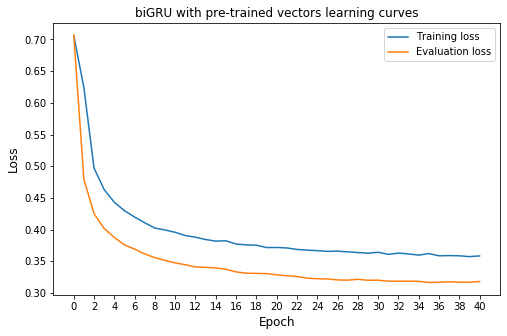

In [34]:
# Plot the training and the validation learning curve
plt.figure(figsize=(8,5))
plt.plot(train_avg_loss_list, label='Training loss')
plt.plot(eval_avg_loss_list, label='Evaluation loss')
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('biGRU with pre-trained vectors learning curves')
plt.xticks(ticks=range(0, 41, 2))
plt.legend()
plt.show()

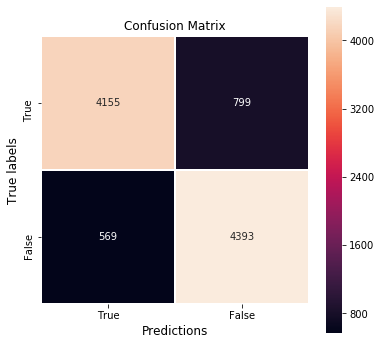

In [44]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

### The generalization error

In [52]:
# Import the dataset. Use clean_review and label columns
test_dataset = pd.read_csv('dataset/datasets_feat_clean/test_feat_clean.csv',
                            usecols=['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                                     'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label'])

# Change columns order
test_dataset = test_dataset[['clean_review', 'polarity', 'subjectivity', 'word_count', 'UPPERCASE', 'DIGITS',
                             'PROPN', 'VERB', 'NOUN', 'PUNCT', 'ADJ', 'label']]

In [53]:
test_dataset.head()

,clean_review,polarity,subjectivity,word_count,UPPERCASE,DIGITS,PROPN,VERB,NOUN,PUNCT,ADJ,label
0,hear film till pop cable tv understand geena o...,-0.01698,0.4990,226,0.01770,0.004425,0.08405,0.1991,0.1903,0.0929,0.05310,1
1,know film show local tv kid remember watch see...,0.03116,0.4822,418,0.09810,0.000000,0.14830,0.1459,0.1698,0.2057,0.06940,0
2,admire kiss mouth frankness  pubic hair cut m...,-0.05817,0.5215,298,0.01342,0.000000,0.03693,0.1544,0.2214,0.1913,0.12760,0
3,see cure kid love year late get hold copy acci...,0.08920,0.5264,757,0.03568,0.000000,0.04755,0.1770,0.1783,0.1625,0.07135,1
4,movie true fact see documentary day early movi...,0.12930,0.4688,186,0.01613,0.000000,0.02689,0.1774,0.1720,0.0914,0.08060,0


In [54]:
# Instantiate the StandardScaler
test_scaler = StandardScaler()
# Scale the features
test_dataset.iloc[:, 3:11] = test_scaler.fit_transform(test_dataset.iloc[:, 3:11])

In [55]:
test_iterator = BatchIterator(test_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                              word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                              unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                              max_seq_len=0.9, use_pretrained_vectors=False, glove_path='glove/',
                              glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
13480/39104 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 187
Mapped words to indices
Batches created


In [56]:
_, test_avg_loss, test_accuracy, test_conf_matrix = model.evaluate_model(test_iterator)

In [57]:
print('Test accuracy: {:.3f}. Test error: {:.3f}'.format(test_accuracy, test_avg_loss))

Test accuracy: 0.862. Test error: 0.319


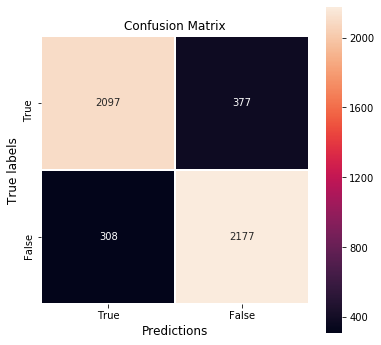

In [58]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(test_conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

The model with pre-trained word embeddings achieved worse result than the previous models. The generalization accuracy equals 0.862. The confusion matrix depicted above shows that the model misclassified the positive examples (377) more times than negative examples (308).